In [76]:
%matplotlib notebook
import numpy as np
import os
import sys
np.random.seed(0)
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
sys.path.append(r'C:\lior\studies\master\projects\calibration\regression calibration\regression_calibration')
os.chdir(r'C:\lior\studies\master\projects\calibration\regression calibration\regression_calibration')
from src.data.data_generator_boneage import BoneAgeDataset
from cqr_model import BreastPathQModel
from uce import uceloss, enceloss
from src.features.calibration_plots import plot_uncert, plot_frequency, plot_uncert_multi
from utils import nll_criterion_gaussian, avg_len
from scaling import set_scaler, scale_bins

matplotlib.rcParams['font.size'] = 8

In [77]:
base_model = 'densenet201'

In [65]:
assert base_model in ['resnet101', 'densenet201', 'efficientnetb4']
device = torch.device("cuda:0")

In [66]:
batch_size = 16
resize_to = (256, 256)

data_set = BoneAgeDataset(data_dir='C:/lior/studies/master/projects/calibration/regression calibration/rsna-bone-age/', augment=False, resize_to=resize_to)
assert len(data_set) > 0

calib_indices = torch.load('./data_indices/boneage_valid_indices.pth')
test_indices = torch.load('./data_indices/boneage_test_indices.pth')

print(calib_indices.shape)
print(test_indices.shape)

calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(calib_indices))
test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                          sampler=SubsetRandomSampler(test_indices))

torch.Size([2000])
torch.Size([4000])


In [67]:
from glob import glob
model_1 = BreastPathQModel(base_model, in_channels=1, out_channels=1).to(device)
model_2 = BreastPathQModel(base_model, in_channels=1, out_channels=1).to(device)

checkpoint_path_1 = glob(f"C:\lior\studies\master\projects\calibration/regression calibration/regression_calibration\models\snapshots\cqr\{base_model}_0.9_boneage_cqr_best.pth.tar")[0]
checkpoint_path_2 = glob(f"C:\lior\studies\master\projects\calibration/regression calibration/regression_calibration\models\snapshots\cqr\{base_model}_0.1_boneage_cqr_best.pth.tar")[0]

checkpoint_1 = torch.load(checkpoint_path_1, map_location=device)
checkpoint_2 = torch.load(checkpoint_path_2, map_location=device)
model_1.load_state_dict(checkpoint_1['state_dict'])
model_2.load_state_dict(checkpoint_2['state_dict'])
print("Loading previous weights at epoch " + str(checkpoint_1['epoch']) + " from\n" + checkpoint_path_1)
print("Loading previous weights at epoch " + str(checkpoint_2['epoch']) + " from\n" + checkpoint_path_2)

Loading previous weights at epoch 380 from
C:\lior\studies\master\projects\calibration/regression calibration/regression_calibration\models\snapshots\cqr\densenet201_0.9_boneage_cqr_best.pth.tar
Loading previous weights at epoch 398 from
C:\lior\studies\master\projects\calibration/regression calibration/regression_calibration\models\snapshots\cqr\densenet201_0.1_boneage_cqr_best.pth.tar


In [68]:
model_1.eval()
t_p_calib_1 = []
targets_calib = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(calib_loader)):
        data, target = data.to(device), target.to(device)

        t_p = model_1(data, dropout=True, mc_dropout=True, test=True)

        t_p_calib_1.append(t_p.detach())
        targets_calib.append(target.detach())

  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 125/125 [04:14<00:00,  2.04s/it]


In [75]:
torch.cat(t_p_calib_1, dim=1).clamp(0, 1).permute(1,0,2)
targets_calib

[tensor([[0.4185],
         [0.5507],
         [0.6828],
         [0.6300],
         [0.5771],
         [0.8150],
         [0.6300],
         [0.5242],
         [0.5242],
         [0.6828],
         [0.3656],
         [0.5242],
         [0.1542],
         [0.6300],
         [0.3656],
         [0.7357]], device='cuda:0'),
 tensor([[0.1542],
         [0.5771],
         [0.6828],
         [0.8414],
         [0.7885],
         [0.6828],
         [0.7885],
         [0.2070],
         [0.5771],
         [0.1542],
         [0.5771],
         [0.3128],
         [0.6564],
         [0.5242],
         [0.5771],
         [0.2335]], device='cuda:0'),
 tensor([[0.6035],
         [0.2599],
         [0.6564],
         [0.7093],
         [0.2203],
         [0.7357],
         [0.2907],
         [0.4626],
         [0.3128],
         [0.7885],
         [0.5242],
         [0.4714],
         [0.4626],
         [0.2070],
         [0.7885],
         [0.5771]], device='cuda:0'),
 tensor([[0.3128],
         [0.

In [9]:
model_2.eval()
t_p_calib_2 = []
targets_calib = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(calib_loader)):
        data, target = data.to(device), target.to(device)

        t_p = model_2(data, dropout=True, mc_dropout=True, test=True)

        t_p_calib_2.append(t_p.detach())
        targets_calib.append(target.detach())

100%|██████████| 125/125 [04:10<00:00,  2.01s/it]


In [39]:
t_p_calib_1 = torch.cat(t_p_calib_1, dim=1).clamp(0, 1).permute(1,0,2)
mu_calib_1 = t_p_calib_1.mean(dim=1)
target_calib = torch.cat(targets_calib, dim=0)

In [ ]:
t_p_calib_2 = torch.cat(t_p_calib_2, dim=1).clamp(0, 1).permute(1,0,2)
mu_calib_2 = t_p_calib_2.mean(dim=1)
target_calib = torch.cat(targets_calib, dim=0)

In [40]:
t_p_test_list_1 = []
mu_test_list_1 = []
target_test_list = []

for i in range(5):
    t_p_test = []
    targets_test = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)

            t_p = model_1(data, dropout=True, mc_dropout=True, test=True)

            t_p_test.append(t_p.detach())
            targets_test.append(target.detach())

        t_p_test = torch.cat(t_p_test, dim=1).clamp(0, 1).permute(1,0,2)
        mu_test = t_p_test.mean(dim=1)
        target_test = torch.cat(targets_test, dim=0)

        t_p_test_list_1.append(t_p_test)
        mu_test_list_1.append(mu_test)
        target_test_list.append(target_test)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [08:32<00:00,  2.05s/it]


In [13]:
t_p_test_list_2 = []
mu_test_list_2 = []
target_test_list = []

for i in range(5):
    t_p_test = []
    targets_test = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)

            t_p = model_2(data, dropout=True, mc_dropout=True, test=True)

            t_p_test.append(t_p.detach())
            targets_test.append(target.detach())

        t_p_test = torch.cat(t_p_test, dim=1).clamp(0, 1).permute(1,0,2)
        mu_test = t_p_test.mean(dim=1)
        target_test = torch.cat(targets_test, dim=0)

        t_p_test_list_2.append(t_p_test)
        mu_test_list_2.append(mu_test)
        target_test_list.append(target_test)

100%|██████████| 250/250 [08:24<00:00,  2.02s/it]


In [44]:
mu_calib_2 = mu_calib_1
mu_test_list_2 = mu_test_list_1

In [45]:
# CQR
import math

def calc_optimal_q(target_calib, mu_calib_1, mu_calib_2, alpha=0.1):

    lower_e = mu_calib_2 - target_calib
    higher_e = target_calib - mu_calib_1
    s_t = torch.max(torch.cat((lower_e, higher_e), -1), -1).values
    s_t_sorted, _ = torch.sort(s_t, dim=0)
    # q_index = math.ceil((len(s_t_sorted) + 1) * (1 - alpha))
    q_index = math.ceil((1 + (1 / (len(s_t_sorted)))) * (1 - alpha))
    q = s_t_sorted[q_index].item()
    # q = torch.quantile(s_t, (1 - alpha))

    return q

q = calc_optimal_q(target_calib, mu_calib_1, mu_calib_2)

In [46]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/regression_calibration/reports/var_and_mse_calib/'
with open(save_path + f'{base_model}_boneage_09_cqr.pickle', 'wb') as handle:
    pickle.dump({'mu': [mu_calib_1, mu_calib_2, mu_test_list_1, mu_test_list_2],
                 'target': [target_calib, target_test_list],
                 'q': q}
                , handle, protocol=pickle.HIGHEST_PROTOCOL)

In [78]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/regression_calibration/reports/var_and_mse_calib/'
with open(save_path + f'{base_model}_boneage_09_cqr.pickle', 'rb') as handle:
    calib_dict = pickle.load(handle)
    mu_calib_1 = calib_dict['mu'][0]
    mu_calib_2 = calib_dict['mu'][1]
    mu_test_list_1 = calib_dict['mu'][2]
    mu_test_list_2 = calib_dict['mu'][3]
    target_calib = calib_dict['target'][0]
    target_test_list = calib_dict['target'][1]
    q = calib_dict['q']

In [30]:
calib = ((target_calib - mu_calib) / uncert_calib)
print(torch.mean(calib))
print(torch.std(calib))

tensor(0.0324, device='cuda:0')
tensor(3.0061, device='cuda:0')


In [31]:
from scipy import stats

calib = [calib_s.item() for calib_s in list(calib.squeeze())]

res = stats.normaltest(calib)
res2 = stats.kstest(calib, cdf=stats.norm.cdf)

print(res.pvalue)
print(res2.pvalue)


4.621411210962452e-08
1.0992930105673419e-110


In [81]:
import math

def calc_optimal_q(target_calib, mu_calib_1, mu_calib_2, alpha=0.1):

    lower_e = mu_calib_2 - target_calib
    higher_e = target_calib - mu_calib_1
    s_t = torch.max(torch.stack((lower_e, higher_e), -1), -1).values
    s_t_sorted, _ = torch.sort(s_t, dim=0)
    # q_index = math.ceil((len(s_t_sorted) + 1) * (1 - alpha))
    q_index = math.ceil(len(s_t_sorted) * (1 - alpha))
    q = s_t_sorted[q_index].item()
    # q = torch.quantile(s_t, (1 - alpha))
    
    return q

In [82]:
#CQR prediction

def set_scaler_conformal(target_calib, mu_calib_1, mu_calib_2, init_temp=2.5, log=True):
    """
    Tune single scaler for the model (using the validation set) with cross-validation on NLL
    """
        
    printed_type = 'CQR'
            
    # Calculate optimal q
    q = calc_optimal_q(target_calib, mu_calib_1, mu_calib_2, alpha=0.1)
    
    after_single_scaling_avg_len = ((mu_calib_1 + q) - (mu_calib_2 - q)).mean()
    print('Optimal scaler {} (val): {:.3f}'.format(printed_type, q))
    print('After single scaling- Avg Length {} (val): {}'.format(printed_type, after_single_scaling_avg_len))
    
    after_single_scaling_avg_cov = avg_cov(mu_calib_1, mu_calib_2, q, target_calib)
    print('After single scaling- Avg Cov {} (val): {}'.format(printed_type, after_single_scaling_avg_cov))
    
    return q

def avg_cov(mu1, mu2, q, target, before=False):
    total_cov = 0.0
    for mu1_single, mu2_single, target_single in zip(mu1, mu2, target):
        if before:
            if mu2_single <= target_single <= mu1_single:
                total_cov += 1.0
        else:
            if mu2_single - q <= target_single <= mu1_single + q:
                total_cov += 1.0
            
    return total_cov / len(mu1)

def scale_bins_single_conformal(mu_test_1, mu_test_2, q):
    
    # Calculate Avg Length before temperature scaling
    before_scaling_avg_len = (mu_test_1 - mu_test_2).mean()
    print('Before scaling - Avg Length: %.3f' % (before_scaling_avg_len))
        
    # Calculate Avg Length after single scaling
    after_single_scaling_avg_len = ((mu_test_1 + q) - (mu_test_2 - q)).mean()
    print('Optimal scaler: %.3f' % q)
    print(f'After single scaling- Avg Length: {after_single_scaling_avg_len}')
    
    return after_single_scaling_avg_len, before_scaling_avg_len


In [61]:
print(sum(mu_calib_1 - mu_calib_2 > 0))

tensor([1608], device='cuda:0')


In [83]:
# CQR
avg_len_before_list = []
avg_len_single_list = []

avg_cov_before_list = []
avg_cov_after_single_list = []

for i in range(len(mu_test_list_1)):
    q = set_scaler_conformal(target_calib, mu_calib_1, mu_calib_2)
                
    avg_len_single, avg_len_before = scale_bins_single_conformal(mu_test_list_1[i], mu_test_list_2[i], q)
    
    avg_cov_before = avg_cov(mu_test_list_1[i], mu_test_list_2[i], q, target_test_list[i], before=True)
    avg_cov_after_single = avg_cov(mu_test_list_1[i], mu_test_list_2[i], q, target_test_list[i])
    
    avg_len_before_list.append(avg_len_before.cpu())
    avg_len_single_list.append(avg_len_single.cpu())
    
    avg_cov_before_list.append(avg_cov_before)
    avg_cov_after_single_list.append(avg_cov_after_single)
    
print(f'Test before, Avg Length:', torch.stack(avg_len_before_list).mean().item())
print(f'Test after single, Avg Length:', torch.stack(avg_len_single_list).mean().item())

print(f'Test before with Avg Cov:', torch.tensor(avg_cov_before_list).mean().item())
print(f'Test after single with Avg Cov:', torch.tensor(avg_cov_after_single_list).mean().item())

Optimal scaler CQR (val): 0.223
After single scaling- Avg Length CQR (val): 0.6278149485588074
After single scaling- Avg Cov CQR (val): 0.9005
Before scaling - Avg Length: 0.182
Optimal scaler: 0.223
After single scaling- Avg Length: 0.62708580493927
Optimal scaler CQR (val): 0.223
After single scaling- Avg Length CQR (val): 0.6278149485588074
After single scaling- Avg Cov CQR (val): 0.9005
Before scaling - Avg Length: 0.182
Optimal scaler: 0.223
After single scaling- Avg Length: 0.6272259950637817
Optimal scaler CQR (val): 0.223
After single scaling- Avg Length CQR (val): 0.6278149485588074
After single scaling- Avg Cov CQR (val): 0.9005
Before scaling - Avg Length: 0.182
Optimal scaler: 0.223
After single scaling- Avg Length: 0.6269978284835815
Optimal scaler CQR (val): 0.223
After single scaling- Avg Length CQR (val): 0.6278149485588074
After single scaling- Avg Cov CQR (val): 0.9005
Before scaling - Avg Length: 0.182
Optimal scaler: 0.223
After single scaling- Avg Length: 0.6270859

In [ ]:
if base_model == 'resnet101':
    uce_range = [0, 0.0044]
elif base_model == 'densenet201':
    uce_range = [0, 0.0012]
elif base_model == 'efficientnetb4':
    uce_range = [0, 0.0008]

n_bins = 15
uce_uncal_list = []
err_uncal_list = []
uncert_uncal_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print((uncert_test[i]**2).max().item())
    # uce_uncal, err_uncal, uncert_uncal, _, uce_per_bin = uceloss(err_test[i]**2, uncert_test[i]**2, n_bins=n_bins, range=uce_range)
    uce_uncal, err_uncal, uncert_uncal, _, uce_per_bin = uceloss(err_test[i]**2, uncert_test[i]**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, uncert_test[i]**2, n_bins=15, single=True)
    uce_uncal_list.append(uce_uncal.cpu())
    err_uncal_list.append(err_uncal.cpu())
    uncert_uncal_list.append(uncert_uncal.cpu())
    ence_bins_list.append(ence_bins.cpu())

print((torch.stack(uce_uncal_list)*100).mean().item(), (torch.stack(uce_uncal_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())
# plot_uncert_multi(err_uncal_list, uncert_uncal_list)

0.008258643560111523
0.008142516016960144
0.008487905375659466
0.008272540755569935
0.008879894390702248
0.31860557198524475 0.0007001719786785543
11.832071304321289


In [ ]:
if base_model == 'resnet101':
    uce_range = [0, 0.0085]
elif base_model == 'densenet201':
    uce_range = [0, 0.016]
elif base_model == 'efficientnetb4':
    uce_range = [0, 0.01]

n_bins = 15
uce_s_list = []
err_s_list = []
uncert_s_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print((scaler_laves(uncert_test_laves[i])**2).max().item())
    # uce_s, err_s, uncert_s, _, uce_per_bin = uceloss(err_test[i]**2, scaler_laves(uncert_test_laves[i])**2, n_bins=n_bins, range=uce_range)
    uce_s, err_s, uncert_s, _, uce_per_bin = uceloss(err_test[i]**2, scaler_laves(uncert_test_laves[i])**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, scaler_laves(uncert_test_laves[i])**2, n_bins=15, single=True)
    uce_s_list.append(uce_s.cpu())
    err_s_list.append(err_s.cpu())
    uncert_s_list.append(uncert_s.cpu())
    ence_bins_list.append(ence_bins.cpu())
    

print((torch.stack(uce_s_list)*100).mean().item(), (torch.stack(uce_s_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())
# plot_uncert_multi(err_s_list, uncert_s_list)

#fig, ax = plot_frequency(scaler_laves(uncert_test_laves[0]).cpu(), in_bin.cpu(), n_bins=n_bins)
#fig.show()

0.021643510088324547
0.022506577894091606
0.02080853283405304
0.021457623690366745
0.021502312272787094
0.06384032219648361 0.0013598145451396704
3.5401382446289062


In [ ]:
#Ethan
n_bins = 15
uce_s_list = []
err_s_list = []
uncert_s_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print(((S*uncert_test[i])**2).max().item())
    print(S)
    uce_s, err_s, uncert_s, _, uce_per_bin = uceloss(err_test[i]**2, (S*uncert_test[i])**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, (S*uncert_test[i])**2, n_bins=15, single=True)
    uce_s_list.append(uce_s.cpu())
    err_s_list.append(err_s.cpu())
    uncert_s_list.append(uncert_s.cpu())
    ence_bins_list.append(ence_bins.cpu())

print((torch.stack(uce_s_list)*100).mean().item(), (torch.stack(uce_s_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())

0.01932200975716114
tensor(1.5296, device='cuda:0')
0.019050316885113716
tensor(1.5296, device='cuda:0')
0.01985839195549488
tensor(1.5296, device='cuda:0')
0.019354522228240967
tensor(1.5296, device='cuda:0')
0.02077549509704113
tensor(1.5296, device='cuda:0')
0.06933446228504181 0.002847395371645689
12.098726272583008


In [ ]:
if base_model == 'resnet101':
    uce_range = [0, 0.0051]
elif base_model == 'densenet201':
    uce_range = [0, 0.007]
elif base_model == 'efficientnetb4':
    uce_range = [0, 0.005]

n_bins = 15
uce_aux_list = []
err_aux_list = []
uncert_aux_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print((aux(uncert_test[i])**2).max().item())
    uce_aux, _, _, _, uce_per_bin = uceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=15, single=True)
    # _, err_aux, uncert_aux, _, uce_per_bin = uceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=n_bins, range=uce_range)
    uce_aux_list.append(uce_aux.cpu())
    ence_bins_list.append(ence_bins.cpu())
    # err_aux_list.append(err_aux.cpu())
    # uncert_aux_list.append(uncert_aux.cpu())

print((torch.stack(uce_aux_list)*100).mean().item(), (torch.stack(uce_aux_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())
# plot_uncert_multi(err_aux_list, uncert_aux_list)

0.016422854736447334
0.016217537224292755
0.016827259212732315
0.016447417438030243
0.017515918239951134
0.07744719833135605 0.0029797477182000875
4.006778240203857


In [ ]:
import seaborn as sns

sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{bm}']

In [ ]:
def save_log(base_model):
    with open(f"results_levi_boneage_{base_model}.log", "w") as f:
        print("MSE", file=f)
        print([(e**2).mean().item() for e in err_test], file=f)
        print("mean", np.mean([(e**2).mean().item() for e in err_test]), file=f)
        print("std ", np.std([(e**2).mean().item() for e in err_test]), file=f)
        print("", file=f)
        
        print("uncal", file=f)
        print("NLL", file=f)
        nll = [nll_criterion_gaussian(mu_test_list[i], uncert_test[i].pow(2).log(), target_test_list[i]).item() for i in range(len(mu_test_list))]
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_uncal_list], file=f)
        print("mean", (torch.stack(uce_uncal_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_uncal_list)*100).var().sqrt().item(), file=f)
        print("", file=f)
        
        print("aux", file=f)
        print("NLL", file=f)
        aux.train()
        nll = [nll_criterion_gaussian(mu_test_list[i], aux(uncert_test[i]), target_test_list[i]).item() for i in range(len(mu_test_list))]
        aux.eval()
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_aux_list], file=f)
        print("mean", (torch.stack(uce_aux_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_aux_list)*100).var().sqrt().item(), file=f)
        print("", file=f)
        
        print("s", file=f)
        print("NLL", file=f)
        nll = [nll_criterion_gaussian(mu_test_list[i], scaler(uncert_test[i]).pow(2).log(), target_test_list[i]).item() for i in range(len(mu_test_list))]
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_s_list], file=f)
        print("mean", (torch.stack(uce_s_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_s_list)*100).var().sqrt().item(), file=f)
        print("S =", scaler.S.item(), file=f)
        print("", file=f)

In [ ]:
if base_model == 'resnet101':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).var(dim=0).sqrt().cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.022], [0, 0.022], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[0].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[0].set_xlim([-0.002, 0.024])
    ax[0].set_ylim([-0.002, 0.024])
    ax[0].set_xticks([0, 0.011, 0.022])
    ax[0].set_yticks([0, 0.011, 0.022])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).var(dim=0).sqrt().cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.006], [0, 0.006], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[1].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[1].set_xlim([-0.0005, 0.0065])
    ax[1].set_ylim([-0.0005, 0.0065])
    ax[1].set_xticks([0, 0.006])
    ax[1].set_yticks([0, 0.006])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.925, 0.075, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).var(dim=0).sqrt().cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.018], [0, 0.018], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[2].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[2].set_xlim([-0.001, 0.019])
    ax[2].set_ylim([-0.001, 0.019])
    ax[2].set_xticks([0, 0.009, 0.018])
    ax[2].set_yticks([0, 0.009, 0.018])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.925, 0.075, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'BoneAge/ResNet-101', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_levi_boneage_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

In [ ]:
if base_model == 'densenet201':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).var(dim=0).sqrt().cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.018], [0, 0.018], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[0].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[0].set_xlim([-0.001, 0.019])
    ax[0].set_ylim([-0.001, 0.019])
    ax[0].set_xticks([0, 0.009, 0.018])
    ax[0].set_yticks([0, 0.009, 0.018])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).var(dim=0).sqrt().cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.012], [0, 0.012], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[1].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[1].set_xlim([-0.001, 0.013])
    ax[1].set_ylim([-0.001, 0.013])
    ax[1].set_xticks([0, 0.006, 0.012])
    ax[1].set_yticks([0, 0.006, 0.012])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.925, 0.075, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).var(dim=0).sqrt().cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.012], [0, 0.012], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[2].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[2].set_xlim([-0.001, 0.013])
    ax[2].set_ylim([-0.001, 0.013])
    ax[2].set_xticks([0, 0.006, 0.012])
    ax[2].set_yticks([0, 0.006, 0.012])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.925, 0.075, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'BoneAge/DenseNet-201', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_levi_boneage_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

<IPython.core.display.Javascript object>


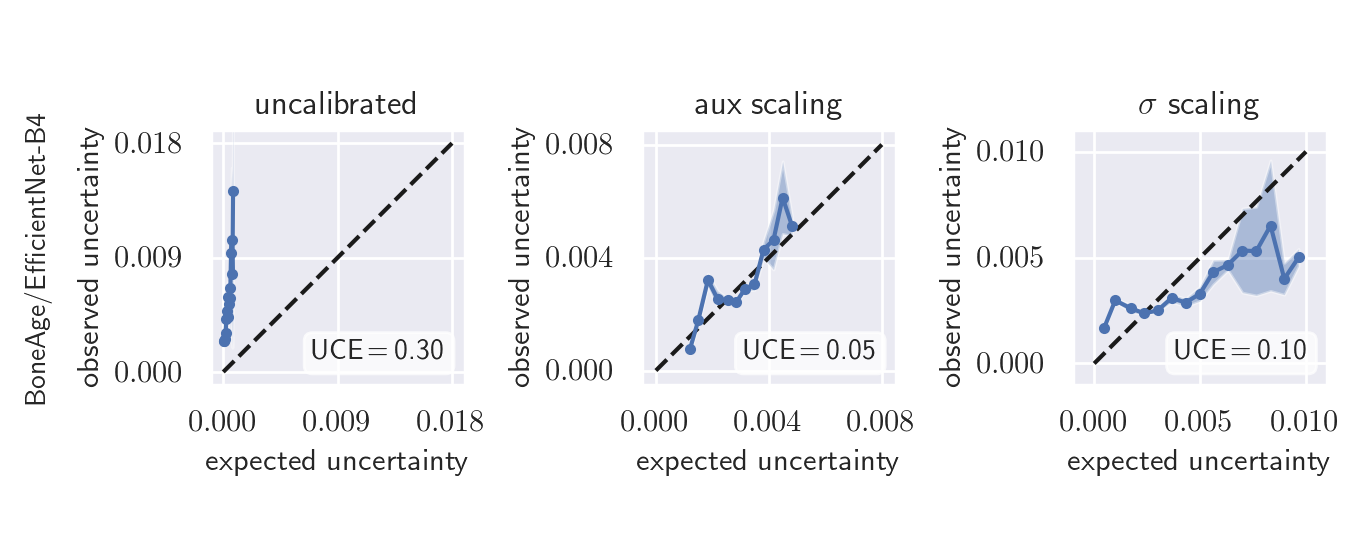

In [ ]:
if base_model == 'efficientnetb4':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).std(dim=0).cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.018], [0, 0.018], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[0].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[0].set_xlim([-0.001, 0.019])
    ax[0].set_ylim([-0.001, 0.019])
    ax[0].set_xticks([0, 0.009, 0.018])
    ax[0].set_yticks([0, 0.009, 0.018])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).std(dim=0).cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.008], [0, 0.008], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[1].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[1].set_xlim([-0.0005, 0.0085])
    ax[1].set_ylim([-0.0005, 0.0085])
    ax[1].set_xticks([0, 0.004, 0.008])
    ax[1].set_yticks([0, 0.004, 0.008])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.925, 0.075, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).std(dim=0).cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.01], [0, 0.01], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[2].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[2].set_xlim([-0.001, 0.011])
    ax[2].set_ylim([-0.001, 0.011])
    ax[2].set_xticks([0, 0.005, 0.01])
    ax[2].set_yticks([0, 0.005, 0.01])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.925, 0.075, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'BoneAge/EfficientNet-B4', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_levi_boneage_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

In [ ]:
np.save(f"uce_uncal_levi_boneage_{base_model}", np.array([i.detach().numpy() for i in uce_uncal_list]))
np.save(f"err_uncal_levi_boneage_{base_model}", np.array([i.detach().numpy() for i in err_uncal_list]))
np.save(f"uncert_uncal_levi_boneage_{base_model}", np.array([i.detach().numpy() for i in uncert_uncal_list]))

np.save(f"uce_s_levi_boneage_{base_model}", np.array([i.detach().numpy() for i in uce_s_list]))
np.save(f"err_s_levi_boneage_{base_model}", np.array([i.detach().numpy() for i in err_s_list]))
np.save(f"uncert_s_levi_boneage_{base_model}", np.array([i.detach().numpy() for i in uncert_s_list]))

np.save(f"uce_aux_levi_boneage_{base_model}", np.array([i.detach().numpy() for i in uce_aux_list]))
np.save(f"err_aux_levi_boneage_{base_model}", np.array([i.detach().numpy() for i in err_aux_list]))
np.save(f"uncert_aux_levi_boneage_{base_model}", np.array([i.detach().numpy() for i in uncert_aux_list]))